# Feedforward network

We have tested a number of configurations:

* **Testing optimizers**
    - Adam(amsgrad=True) > SGD+scheduling > Adam
    - lr scheduling and gradient clipping didn't help either. 
    - Optimal initial learning rate: 1e-3

* **Testing different losses and metrics**
    - RMSE and MAE are fine.
    - MAPE can give extremely high values because incidence is zero a lot of times, not very reliable metric in our case.

* **Testing layers**
    - Batchnorm makes things worse
    - Dropout doesn't make things worse but doesn't improve generalization
    - regularizing dense layer (kernel/activity/bias) didn't helped either
    - RELU performed better than ELU
    - 4 layers, 500 cells seems about the right size
    - He_uniform initialization has slightly faster convergence
    
* **Testing callbacks**
    - ReduceLROnPlateau made things worse
    - EarlyStopping not needed because training is short

In [1]:
# Local imports
import pathlib
import sys
sys.path.insert(0, str(pathlib.Path.cwd().parent / 'src'))

from paths import PATHS
from data.base import make_splits, get_data, single_X_y, unprocess

In [2]:
import matplotlib
import matplotlib.pylab as plt
import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout, Activation, Flatten
import tensorflow.keras.backend as K

In [4]:
df = get_data(trend=True)
splits = make_splits(df,
                     norm=True)
X, y = single_X_y(splits)

/home/iheredia/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [5]:
# Sample weights (recent samples have higher weight)
dates = splits['train']['X'].index.get_level_values(0)
dates = pd.to_datetime(dates)
n = (dates[-1] - dates).days
w = 0.99 ** n  # geometric discount (works better than linear) 

In [6]:
# Formatting for this specific notebook: Transform to arrays of float32
for i in ['train', 'val', 'test']:
    splits[i]['X'] = splits[i]['X'].values.astype(np.float32)
    splits[i]['y'] = splits[i]['y'].values.astype(np.float32)
    splits[i]['y'] = np.expand_dims(splits[i]['y'], -1) # reshape output to (N, 1)

In [7]:
def model_summary(model):
    
    print('\n# Metrics')
    metrics = {'mae': {}, 'mape': {}}
    
    for i in ['train', 'val', 'test']:
        x_t = splits[i]['X']
        y_t = splits[i]['y']

        y_p = model.predict(x_t)
        
        y_t = pd.Series(y_t.squeeze())
        y_p = pd.Series(y_p.squeeze())

        mae = np.abs(y_p - y_t)
        mape = np.abs( (y_p - y_t) / y_t)
        mape = mape.replace([np.inf, -np.inf], np.nan)
        
        metrics['mae'][i] = mae.mean()
        metrics['mape'][i] = mape.mean()

        print(f' - {i.capitalize()}')
        print(f'   Mean Absolute Error (in incidence): {mae.mean():.4f}')
        print(f'   Mean Absolute Percentage Error (in incidence): {mape.mean():.4f}')
        
    return metrics


def save_metrics(metrics, modelname):
    for m in metrics.keys():
        b = pd.DataFrame.from_dict(metrics[m], orient='index', columns=[modelname]).T
        a = pd.read_csv(f'single_step/{m}.csv', index_col=0)
        a = pd.concat([a[~a.index.isin(b.index)], b])
        a.to_csv(f'single_step/{m}.csv')

In [10]:
def build_model(layer_num, layer_cells):

    model = Sequential()
    for i in range(layer_num):
        model.add(Dense(layer_cells,
                        activation="relu",
                        kernel_initializer="he_uniform",
                        name=f"dense{i}"))

    model.add(Dense(1,
                    activation="relu",
                    name="output"))
    return model


keras.backend.clear_session()

model = build_model(layer_num=8, layer_cells=500)

model.compile(loss='MeanSquaredError',
              optimizer=keras.optimizers.Adam(amsgrad=True),
              metrics=['MeanAbsoluteError'])

history = model.fit(x=splits['train']['X'],
                    y=splits['train']['y'],
                    validation_data=(splits['val']['X'],
                                     splits['val']['y']),
                    batch_size=12000,
                    epochs=100,
                    verbose=0,
                    shuffle=True)

model.evaluate(x=splits['train']['X'],
               y=splits['train']['y'],
               sample_weight=w,
              )

print(f"Trained for {len(history.history['loss'])} epochs")

404/404 [==============================] - 1s 2ms/step - loss: 375.1664 - mean_absolute_error: 15.9469
Trained for 100 epochs



# Metrics
 - Train
   Mean Absolute Error (in incidence): 15.9470
   Mean Absolute Percentage Error (in incidence): 0.4812
 - Val
   Mean Absolute Error (in incidence): 39.0170
   Mean Absolute Percentage Error (in incidence): 0.2307
 - Test
   Mean Absolute Error (in incidence): 18.4974
   Mean Absolute Percentage Error (in incidence): 0.3268


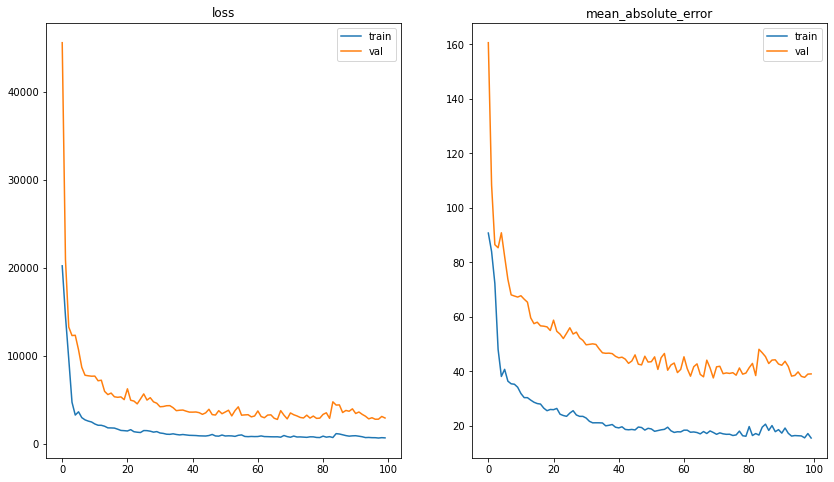

In [11]:
metrics = model_summary(model)

fig, axs = plt.subplots(1,2, figsize=(14,8))
for i, m in enumerate(['loss', 'mean_absolute_error']):
    axs[i].plot(history.history[m], label='train')
    axs[i].plot(history.history[f'val_{m}'], label='val')
    axs[i].set_title(m)
    axs[i].legend()

In [12]:
save_metrics(metrics, 'Feedforward')

y_pred = model.predict(X)
y_pred = np.round(y_pred).astype(np.int)
dfp = pd.DataFrame(y_pred, index=X.index, columns=['Feedforward'])
dfp.to_csv("single_step/pred_ff.csv")

In [11]:
# X_n = unprocess(X, norm=True, log=True)

# # Sanity checks manual computation

# y_pred = model.predict(splits['train']['X'])
# diff = y_pred - splits['train']['y']
# print(np.mean(diff**2))
# print(np.mean(np.abs(diff)))

# mae = tf.keras.metrics.MeanAbsoluteError()
# print(mae(y_pred, splits['train']['y']).numpy())

In [12]:
# # Save model and weights
# if not os.path.isdir(save_dir):
#     os.makedirs(save_dir)
# model_path = os.path.join(save_dir, model_name)
# model.save(model_path)
# print('Saved trained model at %s ' % model_path)

# # Score trained model.
# scores = model.evaluate(x_test, y_test, verbose=1)
# print('Test loss:', scores[0])
# print('Test accuracy:', scores[1])